In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pycaret.clustering import *

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.model_selection import train_test_split

import os
import sys
import datetime

import warnings; warnings.filterwarnings('ignore')

sys.path.append('..')
from config import CFG
CFG = CFG()
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', CFG.NCOLS)
pd.set_option('display.max_rows', CFG.NROWS)

In [148]:
orig = pd.read_csv(os.path.join(CFG.RAW_DATA, 'Pulsar.csv'))
train = pd.read_csv(os.path.join(CFG.RAW_DATA, 'train.csv')).drop(columns='id')
test = pd.read_csv(os.path.join(CFG.RAW_DATA, 'test.csv')).drop(columns='id')

In [149]:
# idx = train.groupby('Class', group_keys=False).apply(lambda x: x.sample(frac=0.02)).index
# sub = train.loc[idx].reset_index(drop=True)
# train = train.drop(idx).reset_index(drop=True)
scaler = RobustScaler()
#train = train.groupby("Class", group_keys=False).sample(frac=0.05).reset_index(drop=True)

X = train.drop('Class', axis=1)
# X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = train['Class']

In [15]:
exp = setup(data=X, normalize=True, normalize_method='zscore', silent=True)

,Description,Value
0,session_id,3528
1,Original Data,"(117564, 8)"
2,Missing Values,False
3,Numeric Features,8
4,Categorical Features,0
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(117564, 8)"
9,CPU Jobs,-1


In [39]:
model = create_model('kmodes', num_clusters=2)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,-0.28,28.09,4.58,0,0,0


In [40]:
results = assign_model(model)
results

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Cluster
0,133.17,59.72,0.04,-0.70,54.92,70.08,0.75,-0.65,Cluster 0
1,87.09,36.26,0.44,2.27,3.42,21.87,7.04,52.69,Cluster 0
2,112.64,39.82,0.38,0.92,2.73,15.69,8.19,85.65,Cluster 0
3,120.68,45.92,-0.10,0.01,2.70,20.95,8.18,70.33,Cluster 0
4,134.07,57.72,-0.11,-0.57,1.11,11.26,16.11,308.75,Cluster 0
...,...,...,...,...,...,...,...,...,...
117559,132.84,56.75,-0.06,-0.55,4.05,27.84,6.56,44.44,Cluster 0
117560,112.58,52.54,0.18,-0.31,1.64,15.33,11.38,142.54,Cluster 0
117561,119.76,49.98,0.06,-0.27,3.88,19.79,6.96,56.37,Cluster 0
117562,105.79,46.99,0.44,0.37,2.10,17.17,9.44,99.07,Cluster 0


In [41]:
results['Cluster'].unique()

array(['Cluster 0', 'Cluster 1'], dtype=object)

In [43]:
results['Class'] = y
results['Cluster'] = results['Cluster'].replace({'Cluster 0': 0, 'Cluster 1': 1})
print(log_loss(results['Class'], results['Cluster']))

3.353288006460837


In [35]:
results['Cluster'] = (results['Cluster'] - 1).abs()

In [42]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

In [150]:
gmm = BayesianGaussianMixture(n_components=3, random_state=42, max_iter=100, n_init=3, tol=10, reg_covar=0.1)
gmm.fit(X)
preds = gmm.predict_proba(X)
df = pd.DataFrame(preds)

In [151]:
df['label'] = y
df[df['label'] == 1].drop('label', axis=1).idxmax(axis=1).value_counts()

2    10526
0      294
1      147
dtype: int64

In [152]:
dfx = df.drop('label', axis=1)
dfx = dfx.apply(lambda x: np.where(max(x) == x, x, 0), axis=1)

In [153]:
dfx = pd.DataFrame(dfx.to_list(), columns=[0, 1, 2], index=dfx.index)
clust1 = dfx[2] #+ dfx[4] + dfx[5]

In [154]:
print(log_loss(y, clust1))

2.9384094661865587


<Axes: ylabel='Frequency'>

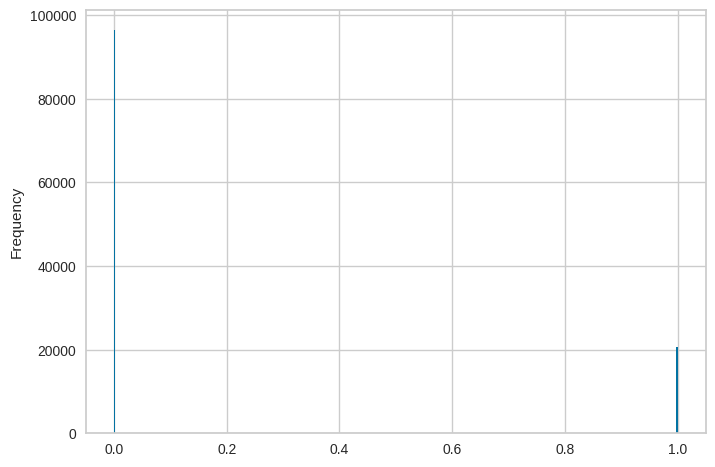

In [155]:
clust1.plot(kind='hist', bins=500)

In [147]:
X

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve
0,0.76,1.65,-0.41,-0.90,25.64,5.31,-2.36,-1.16
1,-1.36,-1.51,0.72,2.47,0.30,0.38,-0.43,-0.42
2,-0.18,-1.03,0.56,0.94,-0.04,-0.25,-0.08,0.03
3,0.18,-0.21,-0.82,-0.09,-0.06,0.29,-0.08,-0.18
4,0.80,1.38,-0.85,-0.76,-0.84,-0.71,2.35,3.10
...,...,...,...,...,...,...,...,...
117559,0.74,1.25,-0.71,-0.73,0.61,0.99,-0.58,-0.54
117560,-0.19,0.68,-0.02,-0.45,-0.58,-0.29,0.90,0.81
117561,0.14,0.34,-0.35,-0.41,0.53,0.17,-0.45,-0.37
117562,-0.50,-0.07,0.74,0.32,-0.35,-0.10,0.31,0.22
